In [2]:
%pip install nltk wordcloud xgboost lightgbm catboost 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip uninstall leia-br -y
%pip install leia-br

Found existing installation: leia-br 0.0.1
Uninstalling leia-br-0.0.1:
  Successfully uninstalled leia-br-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Using cached leia_br-0.0.1-py2.py3-none-any.whl.metadata (2.9 kB)
Using cached leia_br-0.0.1-py2.py3-none-any.whl (130 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Text Processing Libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

# Sentiment Analysis
from LeIA import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, 
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mumu1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mumu1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from IPython.core.display import HTML
HTML('''<style>
div.output_area {
    max-height: none !important;
}
</style>''')

# 출력 제한 완전히 제거
get_ipython().run_line_magic('config', "InlineBackend.print_figure_kwargs = {'bbox_inches': None}") 

In [6]:
from RFM import df_order_reviews, df_product_category_name_translation, df_products, merge_coi

# Merging

In [7]:
# 1) 전체 분석 review_comment_message, product_category_name, order_id
# 2) 이탈고객 vs 잠재우수 고객

df_reviews = df_order_reviews[['order_id', 'review_comment_message']]

# merge_coi + df_products = NLP
NLP = merge_coi.merge(
    df_products[['product_id', 'product_category_name']],  
    on='product_id',
    how='inner'
)

# NLP + df_reviews = NLP
NLP = NLP.merge(
    df_reviews[['order_id', 'review_comment_message']], 
    on='order_id',
    how='inner'
)


# Data cleaning

In [8]:
# 데이터 선택 및 기본 정제
clean_NLP = NLP[['order_id', 'review_comment_message', 'product_category_name']]

# 결측치 제거
clean_NLP = clean_NLP.dropna(subset=['product_category_name', 'review_comment_message'])

# 중복 제거
clean_NLP = clean_NLP.drop_duplicates(subset=['review_comment_message']).reset_index(drop=True)

clean_NLP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33495 entries, 0 to 33494
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   order_id                33495 non-null  object
 1   review_comment_message  33495 non-null  object
 2   product_category_name   33495 non-null  object
dtypes: object(3)
memory usage: 785.2+ KB


# text preprocessing

In [25]:
import re
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode

# ---------------------------------------------------------
# 1. 설정 (불용어 로드)
# ---------------------------------------------------------
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('portuguese'))
# 분석에 불필요한 도메인 특화 불용어 추가
STOP_WORDS.update({
    'dia', 'bom', 'fiz', 'td', 'q', 'mim', 'bem', 'ainda', 'tudo',
    'ra', 'sa', 'ter', 'sido', 'veio', 'vai', 'fazer', 'assim',
    'ate', 'pra', 'pro', 'pela', 'pelo', 'tbm', 'vc', 'eh'
})

# ---------------------------------------------------------
# 2. 전처리 함수
# ---------------------------------------------------------
def clean_and_tokenize(text):
    if not isinstance(text, str):
        return "", []
    
    # [1] 인코딩 깨짐 자동 복구 (nÃ£o -> não)
    try:
        text = text.encode('cp1252').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        pass

    # [2] 소문자 변환 및 유니코드 정규화 (não -> nao)
    text = unidecode(text.lower())
    
    # [3] 특수문자/구두점 -> 공백 치환 (단어 뭉침 방지)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # [4] 숫자 제거
    text = re.sub(r'\d+', '', text)
    
    # [5] 토큰화 (공백 기준)
    words = text.split()
    
    # [6] 불용어 제거 및 길이 필터링 (2글자 이상 유지)
    filtered_words = [
        word for word in words 
        if word not in STOP_WORDS and len(word) > 1
    ]
    
    return " ".join(filtered_words), filtered_words

# ---------------------------------------------------------
# 3. 데이터프레임 파이프라인
# ---------------------------------------------------------
def preprocess_nlp_df(df):
    df = df.copy()
    
    # 전처리 적용
    df[['review_comment_message_clean', 'review_comment_message_tokens']] = df['review_comment_message'].apply(
        lambda text: pd.Series(clean_and_tokenize(text))
    )
    
    # 결측치 및 중복 제거 (메시지 본문 기준)
    df.dropna(subset=['review_comment_message'], inplace=True)
    df.drop_duplicates(subset=['review_comment_message'], inplace=True)
    
    # 빈 결과 제거 (전처리 후 남은 단어가 없는 경우)
    df = df[df['review_comment_message_clean'] != ""]
    
    return df.reset_index(drop=True)

# ---------------------------------------------------------
# 4. 실행 (예시)
# ---------------------------------------------------------
if __name__ == "__main__":
    # clean_NLP = preprocess_nlp_df(clean_NLP)
    pass

clean_NLP.head(20)

,order_id,review_comment_message,product_category_name,review_comment_message_clean,review_comment_message_tokens,token_count
0,6b7d50bd145f6fc7f33cebabd7e49d0f,O baratheon Ã¨ esxelente Amo adoro o baratheon,casa_conforto,baratheon esxelente amo adoro baratheon,"[baratheon, esxelente, amo, adoro, baratheon]",5
1,5741ea1f91b5fbab2bd2dc653a5b5099,Loja responsÃ¡vel,esporte_lazer,loja responsável,"[loja, responsável]",2
2,1ebeea841c590e86a14a0d7a48e7d062,chegou antes do prometido,brinquedos,chegou antes prometido,"[chegou, antes, prometido]",3
3,7433cbcc783205509d66a5260da5b574,"Ã³timo, entregou antes da data prevista.",moveis_decoracao,ótimo entregou antes data prevista,"[ótimo, entregou, antes, data, prevista]",5
4,8428e578bb1cf839ae26a6b7615502b9,Td certo.Produto e prazo de entrega.,automotivo,certo produto prazo entrega,"[certo, produto, prazo, entrega]",4
5,f86c5ed7048ac10eb88ec21c00f71892,"Pena o produto nÃ£o ter sido entregue em casa,...",informatica_acessorios,pena produto entregue casa retirar correios,"[pena, produto, entregue, casa, retirar, corre...",6
6,852d2f4d37773bcbc21c8e09a05a4ea5,Produto chegou no prazo o problema que veio na...,telefonia,produto chegou prazo problema frente capa dani...,"[produto, chegou, prazo, problema, frente, cap...",16
7,eac76692452422620996fe5e1a7f8bb0,Ameiiii !!! excelente produto...excelente qual...,ferramentas_jardim,ameiiii excelente produto excelente qualidade ...,"[ameiiii, excelente, produto, excelente, quali...",9
8,72bab69c50432c6f94d8b50a5f84b69a,Produto chegou antes da data prevista.,automotivo,produto chegou antes data prevista,"[produto, chegou, antes, data, prevista]",5
9,aaff8afa47c8426e414a6d908a97713c,Bom dia eu fiz uma compra de 03 peÃ§as sÃ³ mim...,ferramentas_jardim,compra peças entregarou caixa violada,"[compra, peças, entregarou, caixa, violada]",5



# `SentimentIntensityAnalyzer` in LeIA

In [26]:
# Initialize the Sentiment Analyzer once
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(df, column_name='review_comment_message_clean'):
    # Vectorized function to get sentiment classification
    def get_sentiment_classification(text):
        scores = analyzer.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    # Apply sentiment analysis using map for faster iteration
    df[f'{column_name}_sentiment'] = df[column_name].map(get_sentiment_classification)
    return df

# Classify sentiment in 'clean_NLP' based on the 'review_comment_message_clean' column
clean_NLP = classify_sentiment(clean_NLP, 'review_comment_message_clean')

# Display the sentiment results
clean_NLP[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head(25)

,review_comment_message_clean,review_comment_message_clean_sentiment
0,baratheon esxelente amo adoro baratheon,Neutral
1,loja responsável,Positive
2,chegou antes prometido,Positive
3,ótimo entregou antes data prevista,Positive
4,certo produto prazo entrega,Positive
5,pena produto entregue casa retirar correios,Negative
6,produto chegou prazo problema frente capa dani...,Negative
7,ameiiii excelente produto excelente qualidade ...,Positive
8,produto chegou antes data prevista,Neutral
9,compra peças entregarou caixa violada,Neutral


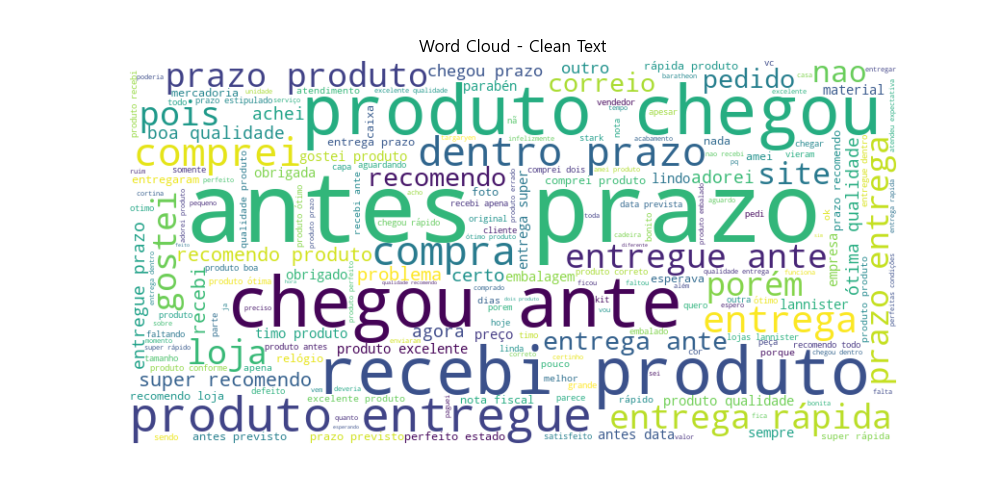

In [30]:
# Concatenate all non-null texts from the 'cleaned_text' column into a single string
text_combined = " ".join(clean_NLP['review_comment_message_clean'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Clean Text")
plt.axis("off")  # Remove the axes
plt.show()